In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the action transformation function
def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

# Define the Replay Buffer class
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert lists of arrays/tensors to tensors
        states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
        actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in next_states])
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        return states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)


    def size(self):
        return len(self.buffer)

# Define the Q-Network class
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

# 1/(1-0.995) = 200
# Define the Agent class
class Agent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(1000000)
        self.batch_size = batch_size
        self.tau = 0.01
        self.gamma = 0.9999
        self.epsilon = 0.9
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.001
        self.model = DQNNetwork(state_size, action_size).to(device)
        self.target_model = DQNNetwork(state_size, action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.action_values = transform_action_values(action_size)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state_tensor):
        if np.random.rand() > self.epsilon:
            action_index = torch.argmax(self.model(state_tensor)).item()
            action = self.action_values[action_index]
        else:
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]
        return action, action_index

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.put((state, action, reward, next_state, done))

    def train_agent(self):
        if self.memory.size() < self.batch_size:
            return

        s_batch, a_batch, r_batch, s_prime_batch, done_batch = self.memory.sample(self.batch_size)

        # Move batches to the cuda through device
        s_batch = s_batch.to(device)
        a_batch = a_batch.to(device).type(torch.int64)
        r_batch = r_batch.to(device)
        s_prime_batch = s_prime_batch.to(device)
        done_batch = done_batch.to(device)

        # Calculate Q values and expected Q values
        q_values = self.model(s_batch).gather(1, a_batch)
        next_q_values = self.target_model(s_prime_batch).detach().max(1)[0].unsqueeze(1)
        expected_q_values = r_batch + self.gamma * next_q_values * (1 - done_batch)

        # Compute loss
        loss = F.smooth_l1_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Soft update the target network
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * tauself.)

# Main training loop
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 21  # number of discrete actions

    agent = Agent(state_size, action_size, batch_size=256)

    EPOCHS = 50
    score_list = []

    for EP in range(EPOCHS):
        state, info = env.reset()
        score = 0
        done = False

        while not done:
            # Convert the state to a tensor and move it to the correct device
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Select an action based on the current state
            action, action_index = agent.select_action(state_tensor)

            # Perform the action in the environment
            next_state, reward, done, truncated, _ = env.step([action])
            if done or truncated:
                done = True
            # Store the experience in the replay buffer
            agent.store_experience(state, action_index, reward, next_state, done)
            # Train the agent
            agent.train_agent()

            # Update the state and accumulate the score
            state = next_state
            score += reward

        # Append the score of the EP to the list for plotting
        score_list.append(score)
        print(f"Episodes {EP + 1}/{EPOCHS}, Score: {score}")

    # Save the model
    torch.save(agent.model.state_dict(), 'pendulum_dqn_model.pth')


Episodes 1/50, Score: -967.4583978119667
Episodes 2/50, Score: -1553.0753535226756
Episodes 3/50, Score: -1755.319789773931
Episodes 4/50, Score: -1435.720023008661
Episodes 5/50, Score: -1365.3399698303635
Episodes 6/50, Score: -1094.468126542528
Episodes 7/50, Score: -665.6779370094404
Episodes 8/50, Score: -1058.2221997729816
Episodes 9/50, Score: -915.6354028404883
Episodes 10/50, Score: -771.5290805916023
Episodes 11/50, Score: -246.4624715891903
Episodes 12/50, Score: -247.99064536029604
Episodes 13/50, Score: -345.0721691312334
Episodes 14/50, Score: -501.88040100419613
Episodes 15/50, Score: -365.8368714867926
Episodes 16/50, Score: -339.7582944915647
Episodes 17/50, Score: -377.94300529534553
Episodes 18/50, Score: -3.9711941216039013
Episodes 19/50, Score: -1225.5844394301391
Episodes 20/50, Score: -125.56817419733576
Episodes 21/50, Score: -240.48821156429253
Episodes 22/50, Score: -123.78568445736616
Episodes 23/50, Score: -124.43372660617378
Episodes 24/50, Score: -340.271

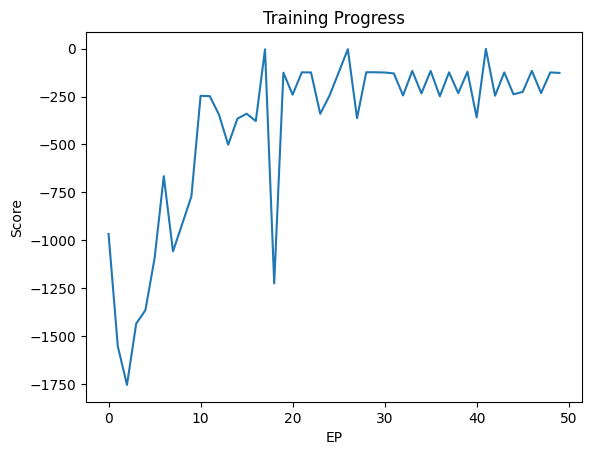

In [2]:
# Plotting the scores
plt.plot(score_list)
plt.xlabel('EP')
plt.ylabel('Score')
plt.title('Training Progress')
plt.show()

In [5]:
# Define a function to run test EPs
def run_test_EPs(env, agent, EPOCHS=10):
    scores = []
    for EP in range(EPOCHS):
        state, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            # Select an action based on the current state
            action, action_index = agent.select_action(state_tensor)
            # Perform the action in the environment
            next_state, reward, done, truncated, _ = env.step([action])
            if done or truncated:
                done = True

        scores.append(total_reward)
        print(f"Test Episodes {EP+1}: Total Reward: {total_reward}")

    env.close()
    return scores

# Load the saved model
agent.model.load_state_dict(torch.load('pendulum_dqn_model.pth'))

# Create a new environment for testing
test_env = gym.make('Pendulum-v1', render_mode='human')

# Run test EPs
test_scores = run_test_EPs(test_env, agent, EPOCHS=10)

# Calculate and print the average score
average_score = sum(test_scores) / len(test_scores)
print(f"Average Score over {len(test_scores)} Episodes: {average_score}")

# Plot the test scores
plt.plot(test_scores)
plt.xlabel('Test Episode')
plt.ylabel('Score')
plt.title('Test Scores of the Trained Model')
plt.show()


Test Episodes 1: Total Reward: 0
Test Episodes 2: Total Reward: 0
Test Episodes 3: Total Reward: 0
Test Episodes 4: Total Reward: 0
Test Episodes 5: Total Reward: 0
Test Episodes 6: Total Reward: 0


KeyboardInterrupt: 

: 